# <center>FloPy Regional Model Development</center>
The following script develops a regional MODFLOW model using FloPy and associated packages. The study domain is American Bottom in Illinois, particulary in the East St. Louis Alluvial plain. 

# 1 Initializing the code


These few code blocks only have to be run at the beginning of the script or if a runtime connection is lost. See details for each below. 

## 1A. Install needed packages


There are three packages that must be installed in the CoLab environment to run this script. These include 

* `pyproj` allows the conversion from WGS84 coordinates (as obtained from Google Earth), which are in lat/long decimal degrees, to Illimap coordinates, a specialized projection using Lambert Conformal Conic that is optimized for developing a model grid in the state of Illinois. 

* `flopy` creates modflow executables, runs the model, and allows for manipulation of results.

* `rasterio` allows for the reading of raster files, and is closely tied to the development of "flopy" input files

In [1]:
!pip install pyproj
!pip install flopy
!pip install rasterio

## 1B. Import packages

In [2]:
import flopy  # import flopy to develop, run, and analyze the model
from flopy.utils import Raster  # plot rasters from flopy
import matplotlib as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer # change between WGS84 and Illimap coordinates
import rasterio  # import rasters
import pylab  # using as a plotting library for spatial data
import seaborn

# the following code authorizes you to access files on Google Drive
from google.colab import drive, files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

flopy is installed in /usr/local/lib/python3.6/dist-packages/flopy


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1C. Authenticate with Google

This will allow you to access shared files on my Google Drive or your own. 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 1D. Read the MODFLOW executable from Google Drive



Here you are going to download the MODFLOW executable from Daniel's Google Drive. This will show up in your temporary working directory for use later in the code. <b>We need to confirm whether this will work in CoLab, or if you need to compile a new version of MODFLOW each time.</b>

Note that this makes use of a key on your Google Drive sharable link for the file. This generally takes the form of: https://drive.google.com/file/d/**key**/view?usp=sharing, in this case, key = 1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V

In [0]:
downloaded = drive.CreateFile({'id':"1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V"}) # This is the key that is defined in the sharable link of a file on Google Drive
downloaded.GetContentFile('mf2005') # get the content from Google Drive and name it (let's stick with mf2005 here)

Now we need to copy the executable into a location where we can later run it. Note that the "!" nomenclature is a shell command, beyond the scope of this course to learn that!

In [0]:
!cp mf2005 /usr/local/bin
!chmod 755 /usr/local/bin/mf2005

# 2 Import the big stuff


We don't want to repeatedly import large files for fear of Google revoking our CoLab priveleges for a few hours. Once or twice isn't a big deal, but repeatedly might be an issue. Let Daniel know if this happens- there are ways to reduce our file sizes. 

For now, the "big stuff" includes a DEM of Illinois and the river excel file we worked with last time. 

## 2A. Import the DEM

In [0]:
# first import the land surface .tif from Google Drive
downloaded = drive.CreateFile({'id':"1389l8sgQ8-tsmIZuZosaqvbqpHY40n6l"})
downloaded.GetContentFile('landsurface_el.tif')

# first import the bedrock elevation .tif from Google Drive
downloaded = drive.CreateFile({'id':"1EZgZDjjILzvRzvY9nf0Qp0NHmspRq4kP"})   
downloaded.GetContentFile('bedrock_el.tif')

# read in percent thickness of coarse grain for each model layer
downloaded = drive.CreateFile({'id':"18Kw3O6qCzIJ2L6KrVnRPIhea_F8VwyWn"})   
downloaded.GetContentFile('percentl1.tif')

downloaded = drive.CreateFile({'id':"1oZinFPKrGY-FXoE7Zu0okFpAAOe_bwau"})   
downloaded.GetContentFile('percentl2.tif')

downloaded = drive.CreateFile({'id':"1FqVEr4m_ElUyEZeyfnCMwVGDfUqavJZH"})   
downloaded.GetContentFile('percentl3.tif')

downloaded = drive.CreateFile({'id':"1KiHS9TLSP1GAVTjaaJZS4BAwF6gnUeDu"})   
downloaded.GetContentFile('percentl4.tif')

downloaded = drive.CreateFile({'id':"1Z-9EyaAK1NKnRHAlnyGYkI3suvBFC2I6"})   
downloaded.GetContentFile('percentl5.tif')

downloaded = drive.CreateFile({'id':"1pcB9aJpJGfkXOKz10rhs6MpWkQL1_dqr"})   
downloaded.GetContentFile('percentl6.tif')

downloaded = drive.CreateFile({'id':"1Fnh0HIKbUj7pEtlsUKR_Sr7WwfYzWul5"})   
downloaded.GetContentFile('percentl7.tif')

downloaded = drive.CreateFile({'id':"106JacgpwSA3wVAGcBIzGdc8rDVUB6dh7"})   
downloaded.GetContentFile('percentl8.tif')

downloaded = drive.CreateFile({'id':"1WJjhVJ_KSBhZDrgzY3YteNjxaz5nxBid"})   
downloaded.GetContentFile('percentl9.tif')

## 2B. Import the river file

In [0]:
# first import the Excel file from Google Drive
downloaded = drive.CreateFile({'id':"1JsAiGG4RvcfYrQtfgXRW9ZVfAkQ1yRVu"})
downloaded.GetContentFile('rivers_625.csv')

# 3 Create MODFLOW  packages

## 3A. Model Set-up

### 3Ai. Define the Model Domain

In [0]:
#ESL project area
sw_lat = 38.4  #southwest latitude
sw_long = -90.25  #southwest longitude
ne_lat = 39  #northeast latitude
ne_long = -89.85  #northeast longitude
illimap = {
    'proj': 'lcc',  # Lambert Conformal Conic
    'ellps': 'clrk66',
    'lon_0': -89.5,
    'lat_0': 33,
    'lat_1': 33,
    'lat_2': 45,
    'x_0': 2999994 * 0.3048006096012192,
    'y_0': 0
}
# "transformer" can project lats & longs into lambert coordinates
transformer = Transformer.from_crs("epsg:4326", illimap)
nex, ney = transformer.transform(ne_lat, ne_long)
swx, swy = transformer.transform(sw_lat, sw_long)
#  convert the Lambert coordinates from meter to ft
nex, ney = round(nex / 0.3048006096, -4), round(ney / 0.3048006096, -4)
swx, swy = round(swx / 0.3048006096, -4), round(swy / 0.3048006096, -4)

### 3Aii. Define spatial and temporal discretization

In [0]:
# Assign Discretization variables
Lx = nex - swx  # Width of the model domain
Ly = ney - swy  # Height of the model domain
nlay = 10  # Number of model layers
dx = 1000  # grid length
dy = 1000  # grid width
nrow = int(Ly / dy)  # Total number of rows = 220
ncol = int(Lx / dx)  # Total number of columns = 110
nper = 1  #specify number of stress periods
steady = [True]  #specify if stress period is transient or steady-state

### 3Aiii. Define river elevations



In [0]:
"""Function that can find corresponding rows and columns."""
# np.trunc() can round decimals to integers


def truncate(df, lamx, lamy):
    df['row'] = np.trunc((ney - df[lamy]) / dy).astype('int')
    df['col'] = np.trunc((df[lamx] - swx) / dx).astype('int')
    return

In [11]:
# import stage, lambert x, lambert y
dfriv = pd.read_csv('rivers_625.csv')
# trim dataframe with river information to the model domain
dfriv = dfriv.loc[dfriv['lamx'] < nex]
dfriv = dfriv.loc[dfriv['lamy'] < ney]
dfriv = dfriv.loc[dfriv['lamx'] > swx]
dfriv = dfriv.loc[dfriv['lamy'] > swy]
dfriv['lay'] = 0  # assign rivers to the topmost layer
"""Convert lamx to column and lamy to row
(determine the exact position of rivers in the model)."""
truncate(dfriv, 'lamx', 'lamy') # find corresponding rows and columns
dfriv['stage'] = dfriv['rvr_stg']  # the river stage
dfriv['cond'] = 5914.6  # unit: ft^2/d # the conductance
"""Define the river bottom. The average depth is around 20 ft."""
dfriv['bot'] = dfriv['stage'] - 20
# drop unneeded files
dfriv = dfriv.drop(
    ['STR_ORD_MI', 'STR_ORD_MA', 'SUM_LENGTH', 'rvr_stg', 'lamx', 'lamy'],
    axis=1)
"""Grouping repetitive river data"""
# groupby() can combine Dataframe indices with the same coordinates.
dfriv = dfriv.groupby(['lay', 'row', 'col'], as_index=False).mean()
print(dfriv.head(5))

   lay  row  col  stage    cond    bot
0    0   39    9  417.0  5914.6  397.0
1    0   40   11  417.0  5914.6  397.0
2    0   41   12  417.0  5914.6  397.0
3    0   41   35  408.0  5914.6  388.0
4    0   42   14  417.0  5914.6  397.0


### 3Aiv. Define top and bottom elevations

In [0]:
"""Import the surface and bedrock DEM and assign the elevation for each cell
on the top or bottom layer in our model."""
# Now load the raster using FloPy's built in Raster toolbox
illinoisdem = Raster.load("landsurface_el.tif")
bedrock = Raster.load("bedrock_el.tif")
# Crop the DEM to the model domain
illinoisdem.crop([(swx, swy), (swx, ney), (nex, ney), (nex, swy)])
bedrock.crop([(swx, swy), (swx, ney), (nex, ney), (nex, swy)])
# Define centroid of the southwestern most cell
startx = swx + dx / 2
starty = swy + dy / 2
# Calculate the x and y coordinates for the centroid of each cell
xc = np.arange(swx + dx / 2, nex + dx / 2, dx)  # np.arange(start,end,interval)
yc = np.arange(swy + dy / 2, ney + dy / 2, dy)
# Create a grid of the x coordinate of each centroid and the y coordinate
xarr, yarr = np.meshgrid(xc, yc)
# resample the topo raster to the grid of centroids of the model
topgrid = illinoisdem.resample_to_grid(xarr, yarr, 1, method='nearest')
bedrock = bedrock.resample_to_grid(xarr, yarr, 1, method='nearest')
# We just built our top elevation upside down, let's flip it
topgrid, bedrockgrid = np.flipud(topgrid), np.flipud(bedrock)
"""The grid does not extend past the boundaries of Illinois.
Inactivate cells west of the Mississippi River that were originally not present.
Note that because inactive cells would overlap with the river boundaries, 
this code pushes inactive cells to the west by 4 cells."""
# Create ibound as array of ints (1), indicating all cells are active
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
for row in np.arange(nrow, 0, -1):
    # how far west to shift inactive cell
    counter = 0
    for col in np.arange(ncol, 0, -1):
      # "row-1" is because python indices start from 0
        if topgrid[row - 1, col - 1] <= -50:  
            counter += 1
            # "backfill" the data
            topgrid[row - 1, col - 1] = topgrid[row - 1, col]
            bedrockgrid[row - 1, col - 1] = bedrockgrid[row - 1, col]
            if counter >= 4:  # only backfill 4 grids on the maximum
                ibound[:, row - 1, col - 1] = 0

In [0]:
"""Define the top of river cells. Define the bottom of each layer."""
# Set the top of Layer 1 = River Elevation
for index, row in dfriv.iterrows():
    topgrid[int(row['row']), int(row['col'])] = row['stage']
# Make sure that all layers （combined) are at least 9 ft thick
diff = topgrid - bedrockgrid
diff[diff <= 9.0] = 9.0
# each layer has the same thickness, we need 9 glacial layers
laythick = diff / 9
#calculate the bottom of each layer
lay1bot = topgrid - laythick
lay2bot = topgrid - 2 * laythick
lay3bot = topgrid - 3 * laythick
lay4bot = topgrid - 4 * laythick
lay5bot = topgrid - 5 * laythick
lay6bot = topgrid - 6 * laythick
lay7bot = topgrid - 7 * laythick
lay8bot = topgrid - 8 * laythick
lay9bot = topgrid - 9 * laythick
lay10bot = lay9bot - 50.
botgrids = [
    lay1bot, lay2bot, lay3bot, lay4bot, lay5bot, lay6bot, lay7bot, lay8bot,
    lay9bot, lay10bot
]

### 3Av. Assign hydraulic conductivity and calculate transmissivity

In [0]:
"""Adjust conductivity in calibration (unit: ft/day)"""
kvc = 48  # predominantly very coarse
kc = 14  # predominantly coarse
kf = 1.1  # predominantly fine
kb = 20  # bedrock

# determine how to assign hydrualic conductivity
threshold1 = 55  # layer 1 to 6: above this will be assigned kc and below kf
threshold2 = 30  # layer 7 to 9: above this will be assigned kvc and below kc


def kloader(rastername, k1, k2, threshold):
    percent = Raster.load(rastername)  # load raster
    percent.crop([(swx, swy), (swx, ney), (nex, ney),
                  (nex, swy)])  # crop array
    percentgrid = percent.resample_to_grid(
        xarr, yarr, 1, method='nearest')  # resample to model grid
    percentgrid = np.flipud(percentgrid)  # flip the grid
    for row in np.arange(nrow, 0, -1):  # assign values to outliers
        for col in np.arange(ncol, 0, -1):
            if percentgrid[row - 1, col - 1] < -10:
                percentgrid[row - 1, col - 1] = percentgrid[row - 1, col]
    for row in np.arange(nrow, 0, -1):  # assign k based on the threshold
        for col in np.arange(ncol, 0, -1):
            if percentgrid[row - 1, col - 1] >= threshold:
                percentgrid[row - 1, col - 1] = k1
                continue
            else:
                percentgrid[row - 1, col - 1] = k2
    return percentgrid

In [0]:
''' computing the hydraulic conductivity of the model '''
kl1 = kloader('percentl1.tif', kc, kf, threshold1)
kl2 = kloader('percentl2.tif', kc, kf, threshold1)
kl3 = kloader('percentl3.tif', kc, kf, threshold1)
kl4 = kloader('percentl4.tif', kc, kf, threshold1)
kl5 = kloader('percentl5.tif', kc, kf, threshold1)   
kl6 = kloader('percentl6.tif', kc, kf, threshold1)
kl7 = kloader('percentl7.tif', kvc, kc, threshold2)
kl8 = kloader('percentl8.tif', kvc, kc, threshold2)
kl9 = kloader('percentl9.tif', kvc, kc, threshold2)
kl10 = kl9 - kl9 + kb

khlayers = [kl1, kl2, kl3, kl4, kl5, kl6, kl7, kl8, kl9, kl10]
kvlayers = np.divide(khlayers, 10.)

In [0]:
"""Computing the Transmissivity of the model based on hydraulic conductivity"""
# each layer has the same thickness accounting for 9 glacial layers 
T1 = khlayers[0]*laythick
T2 = khlayers[1]*laythick
T3 = khlayers[2]*laythick
T4 = khlayers[3]*laythick
T5 = khlayers[4]*laythick
T6 = khlayers[5]*laythick
T7 = khlayers[6]*laythick
T8 = khlayers[7]*laythick
T9 = khlayers[8]*laythick
T10 = khlayers[9]*50
# arranging the values in a list
Tlayers = [T1, T2, T3, T4, T5, T6, T7, T8, T9, T10]
# computing the total transmissivity by summing each layer
T_total = T1 + T2 + T3 + T4 + T5 + T6 + T7 + T8 + T9 + T10 
# We just built our transmissivity upside down, let's flip it.
T_flipped = np.flipud(T_total)

###3Avi. Well pumpage data cleansing

Before assigning modified well pumpage data to the model, we need to carry out data cleansing to remove some data that do not meet the necessary modeling requirement. The year 1995 is the one that our model is concerned about. The modified well pumpage data is imported, and then items that satisfy the following conditions are dropped from the Dataframe:
  
1. Items with too large depth;
2. Items if their x-coordinates exceed the model boundary;
3. Items if their y-coordinates exceed the model boundary;
4. Items with no values recorded, either pumpage in 1995 or coordinates.

In [0]:
"""Remove any item that loses data or does not meet the model requirement."""


def modify_pumpage(year: str):
    dfpump = pd.read_csv(
        'https://raw.githubusercontent.com/Firas-95/GEO572-Project-E.St.Louis/class_example/yiquan/pumping/Modified_Pumpage_Data_ESL.csv'
    )
    dfpump.rename(columns={'depth_total_last_known': 'depth'}, inplace=True)
    list_drop = []
    for ind, row in dfpump.iterrows():
        if row['depth'] > 150:  # too large depth
            list_drop.append(ind)
            continue
        elif row['lam_x'] > nex or row['lam_x'] < swx:  # "lam_x" exceeds
            list_drop.append(ind)
            continue
        elif row['lam_y'] > ney or row['lam_y'] < swy:  # "lam_y" exceeds
            list_drop.append(ind)
    dfpump = dfpump.drop(list_drop)
    # Drop item with no value
    dfpump = dfpump.dropna(subset=["lam_x", "lam_y", "depth", year], how='any')
    modified_pump = dfpump[["lam_x", "lam_y", "depth", year]]
    modified_pump.index = range(len(modified_pump))
    return modified_pump

Note that some data are dropped due to a lack of coordinates. However, they do report considerable pumpage in 1995. To avoid the error caused by the incomplete data, we need to manually ascertain their coordinates and add them to the model.

In [0]:
dflost = pd.read_excel(
    "https://github.com/Firas-95/GEO572-Project-E.St.Louis/blob/class_example/yiquan/pumping/ESL_lost_coordinates.xlsx?raw=true"
)
# Convert lost well lat & long coordinates into lambert coordinates (ft) 
lat_list, long_list = dflost["lat"].tolist(), dflost["long"].tolist()
lat_list, long_list = transformer.transform(lat_list, long_list)
dflost["lam_x"] = [round(i/ 0.3048006096,0) for i in lat_list]
dflost["lam_y"] = [round(j / 0.3048006096,0) for j in long_list]
dflost.rename(columns={1995: '1995'}, inplace=True)
dflost = dflost.reindex(columns=['lam_x', 'lam_y', 'depth', '1995'])

When using `groupby()` method, we want to add up the pumpage and average the depth. To avoid disorder, `groupby().mean()` and `groupby().sum()` is used separately.

In [0]:
"""Adjust the modified data to meet the input requirement."""
pump95 = modify_pumpage("1995")
pump95 = pd.concat([pump95, dflost])
truncate(pump95, 'lam_x', 'lam_y')  # # find corresponding rows and columns
pump95 = pump95.drop(['lam_x', 'lam_y'], axis=1)
# We want to add up the pumpage and average the depth
pump95_2 = pump95.groupby(['row', 'col'], as_index=False).sum()
pump95 = pump95.groupby(['row', 'col'], as_index=False).mean()
pump95_2['1995'] = round(-pump95_2['1995'] / 7.48052 / 365, 2)  # unit ft/d
pump95['1995'] = pump95_2['1995']
"""Build the pumpage data and put them in a list[[lay, row, col, flux]]."""
pumplist = []
for ind, row in pump95.iterrows():
    a, b, c, d = int(row['row']), int(row['col']), row['depth'], row['1995']
    # Judge which layer can a pumping well can go into.
    for i in np.arange(9, 0, -1):
        if c > topgrid[a][b] - botgrids[i][a][b]:
            # Add pumpage data in the [lay, row, col, flux] format.
            pumplist.append([i, a, b, d])
            break

###3Avii. Drain cells set-up

In [0]:
"""Acquire a dataframe that contains all drain cells."""
drain = {
    'row': np.where(kl1 == kf)[0],
    'col': np.where(kl1 == kf)[1]
}  # np.where() returns all indices where the conductivity is low
dfdrn = pd.DataFrame(drain)
dfdrn['lay'] = 0
dfdrn['cond'] = kf * dx * dy / laythick.mean()  # conductance unit: ft^2/day
dfdrn['stage'] = topgrid[dfdrn['row'], dfdrn['col']]
dfdrn = dfdrn.reindex(columns=['lay', 'row', 'col', 'stage',
                               'cond'])  # rearrange the columns
"""Drop drain cells where they have already been assigned as inactive cells."""
dfdrn_droplist = []
for ind, row in dfdrn.iterrows():
    if ibound[0][dfdrn.iloc[ind, 1]][dfdrn.iloc[ind, 2]] == 0:
        dfdrn_droplist.append(ind)
dfdrn = dfdrn.drop(dfdrn_droplist)

### 3Aviii. Recharge set-up

In [0]:
"""Specify recharge zone based on hydraulic conductivity."""
rech = kl1.copy()
# Assume recharge is proportional to the conductivity.

rech = np.where(rech == kc, 0.002, 0.0006)
# ibound_zero = ibound[0]
ibound_zero = np.where(ibound[0] == 0)
# ibound_zero_col = np.where(ibound_zero == 0)[1]
for i in range(len(ibound_zero[0])):
    rech[ibound_zero[0][i], ibound_zero[1][i]] = 0

''' For plotting purposes '''
rch_flipped = np.flipud(rech)

## 3B. Create the MODFLOW model object 

In [0]:
# Create a MODFLOW model object and run with MODFLOW 2005.
modelname = "my_model"  # name the model
m = flopy.modflow.Modflow(modelname, version='mf2005',
                          exe_name='mf2005')  # create model object m

## 3C. Append the discretization package to the model object

In [0]:
# length and time are feet (1) and days (4).
# See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=topgrid, botm=botgrids, 
                               itmuni = 4, lenuni = 1, nper=nper, steady=steady)

## 3D. Basic Package

In [0]:
#Create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=topgrid)

## 3E. LPF Package

In [0]:
#define layer type as convertible (1) or confined (0), must be an integer
laytyp = np.zeros((nlay, ), dtype=np.int32)
#print(laytyp)  # result: [0 0 0 0 0 0 0 0 0 0]
# create the LPF object
lpf = flopy.modflow.ModflowLpf(model=m, hk=khlayers, vka=kvlayers,
                               laytyp=laytyp, ipakcb=1)

## 3F. Boundary Conditions

### 3Fi. Recharge Package

In [0]:
# assign recharge to the model
rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=1, rech=rech)

### 3Fii. River Package

In [0]:
# put into a format that MODFLOW wants
arriv = dfriv.values
riverdata = {0: arriv}
# create river package
riv = flopy.modflow.mfriv.ModflowRiv(model=m, ipakcb=None,
                                     stress_period_data=riverdata)

### 3Fiii. Drain Package


In [0]:
# Put into a format that MODFLOW wants
ardrn = dfdrn.values
draindata = {0: ardrn}
# create drain package
drn = flopy.modflow.mfdrn.ModflowDrn(model=m, ipakcb=None,
                                     stress_period_data=draindata)

### 3Fiv. Well Package

In [0]:
pumpagedata = {0: pumplist}
pum = flopy.modflow.mfwel.ModflowWel(model=m, ipakcb=None,
                                     stress_period_data=pumpagedata)

## 3G. Define output control

In [0]:
#create oc stress period data.
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
#create output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 3H. Solver

In [0]:
# We will start by using the PCG solver with default settings
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=200, iter1=50, hclose=1e-03,
                               rclose=1e-03, relax=0.98, damp=0.3)

## 3I. Plot model inputs (boundary conditions, elevations, etc.)

To simplify plotting codes, we define two *functions* that create a map and add basic features to the map, including titles, labels, ibound, and rivers.

In [0]:
"""Function that generates a map."""
def newmap(title, figsize=(20,20), fontsize=16, titlesize=22):
  plt.figure(figsize=figsize, facecolor="white")
  plt.xlabel('Lx (ft)', fontsize=fontsize)
  plt.ylabel('Ly (ft)', fontsize=fontsize)
  plt.title(title, fontsize=titlesize, fontweight='bold')
  model_map = flopy.plot.PlotMapView(model=m, layer=0)
  seaborn.despine() # remove map boundary  
  return model_map


"""Function that add ibound and a river."""
def add_ibound_riv(flag=0):
  modelmap.plot_bc(ftype='RIV', color='aqua')
  modelmap.plot_ibound()
  if flag==1: # when flag=1, also add legend.
    plt.legend(handles=[
      mp.patches.Patch(color='aqua', label='River'),
      mp.patches.Patch(color='black', label='Inactive')]
      ,loc="lower right", framealpha=0.3, fontsize=12)
  return


"""Create meshgrids for the model, they will be used in maps with a color flood."""
# x and y are located on the centeroid of each grid
x = xc - np.min(xc) + dx / 2
y = yc - np.min(yc) + dy / 2
X, Y = np.meshgrid(x, y)

/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


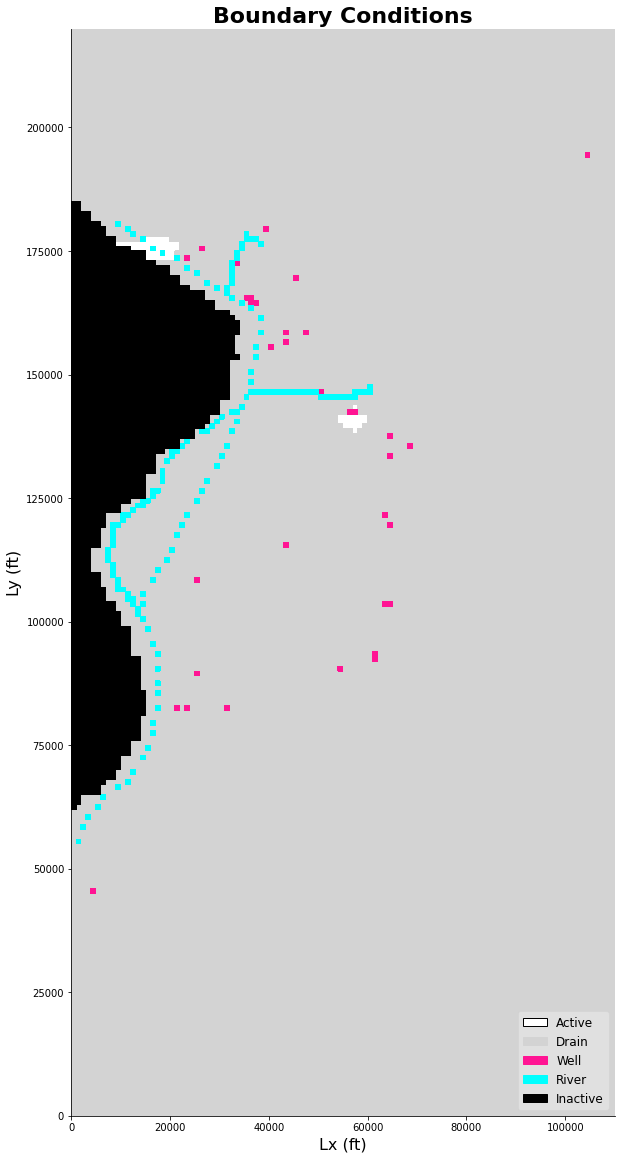

In [33]:
"""Plot boundary conditions"""
modelmap = newmap("Boundary Conditions")
modelmap.plot_bc(ftype='DRN', color='lightgrey')
modelmap.plot_bc(ftype='WEL', color='deeppink', plotAll=True)
# Add legend
plt.legend(handles=[
    mp.patches.Patch(color='white', label='Active', ec='black'),
    mp.patches.Patch(color='lightgrey', label='Drain'),
    mp.patches.Patch(color='deeppink', label='Well'),
    mp.patches.Patch(color='aqua', label='River'),
    mp.patches.Patch(color='black', label='Inactive')], 
    fontsize=12, loc="lower right", framealpha=0.3)
add_ibound_riv() # add ibound and a river
plt.show()

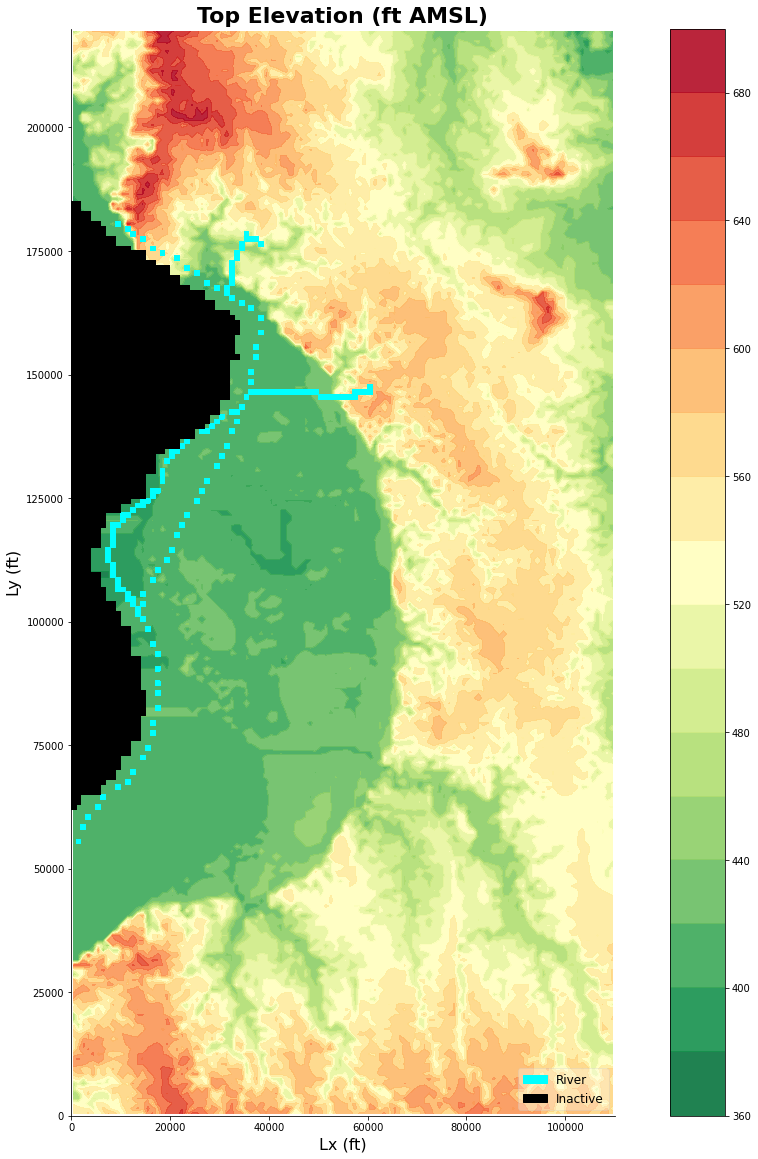

In [34]:
"""Plot top elevation."""
newmap('Top Elevation (ft AMSL)')
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0)
# Create a color flood and add colorbar
plt.colorbar(plt.contourf(X, Y, topgrid, 16, alpha=0.9, cmap=plt.cm.RdYlGn_r))
add_ibound_riv(1) # add ibound and a river
plt.show()

In [0]:
"""Plot the transects we are concerned about in milestone 1."""


def plot_transect(titlename, rowcolflag=0, value=0):
    # rowcolflag: indicates whether the transect is on the row or the column
    if rowcolflag == 0:
        plt.figure(figsize=(10, 4), facecolor="white")
        modelxsect = flopy.plot.PlotCrossSection(model=m, line={"row": value})
        plt.xlabel("Lx (ft)", fontsize=14)
    elif rowcolflag == 1:
        plt.figure(figsize=(20, 4), facecolor="white")
        modelxsect = flopy.plot.PlotCrossSection(model=m, line={"column": value})
        plt.xlabel("Ly (ft)", fontsize=14)
    # Create colormap of named colors
    colors = ["saddlebrown", "lightgray", "lightgoldenrodyellow"]
    cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
    norm = mp.colors.LogNorm(vmin=kf, vmax=kvc)
    khlaynp = np.array(khlayers)
    lines = modelxsect.plot_array(khlaynp, norm=norm, cmap=cmap)
    # Add rivers, wells and ibound
    modelxsect.plot_bc(ftype='RIV', color='aqua')
    modelxsect.plot_bc(ftype='WEL', color='deeppink')
    modelxsect.plot_ibound()
    plt.title(titlename, fontsize=18, fontweight='bold')
    plt.ylabel("Elevation, ft AMSL", fontsize=14)
    plt.legend(handles=[
        mp.patches.Patch(color='saddlebrown', label='fine'),
        mp.patches.Patch(color='#D8D8D3', label='coarse'),
        mp.patches.Patch(color='lightgoldenrodyellow', label='very coarse'),
        mp.patches.Patch(color='#EBEBD2', label='bedrock')], 
        framealpha=0.3, loc="lower right", fontsize=12)
    plt.show()
    return

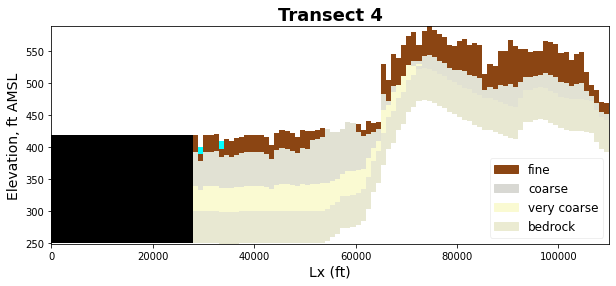

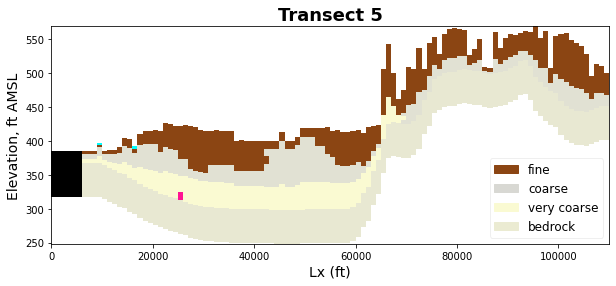

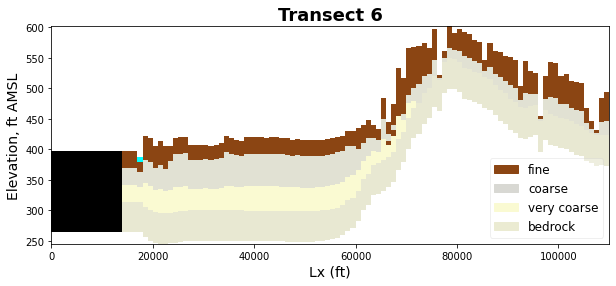

In [36]:
# Plot the 3 east-west transects
plot_transect("Transect 4", rowcolflag=0, value=79)  # transect 4: 38.785N
plot_transect("Transect 5", rowcolflag=0, value=111)  # transect 5: 38.698N
plot_transect("Transect 6", rowcolflag=0, value=132)  # transect 6: 38.640N

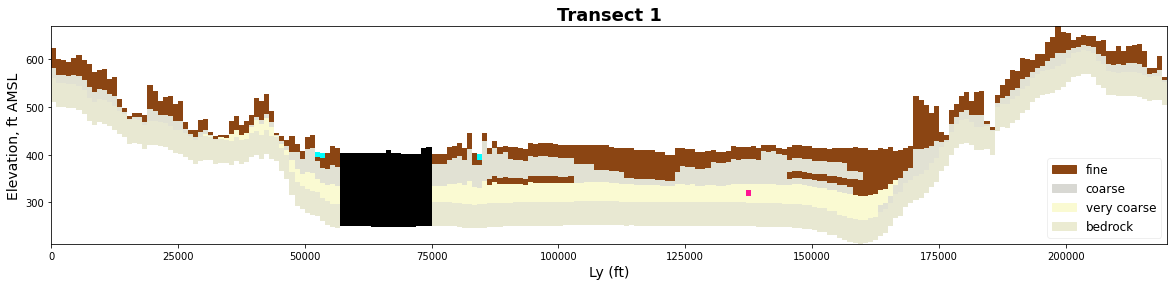

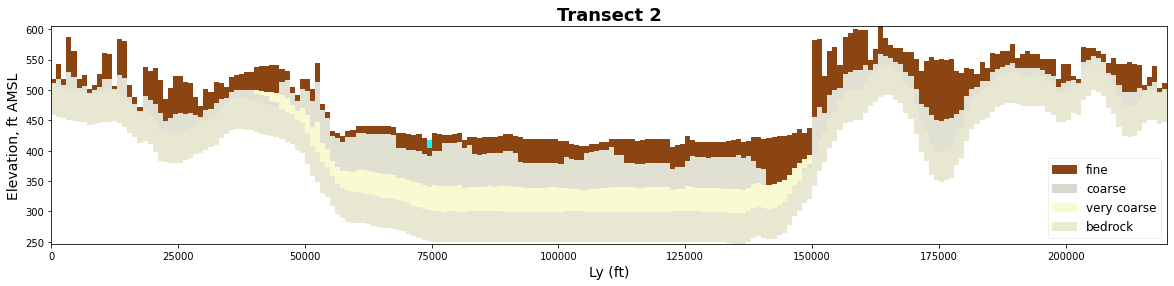

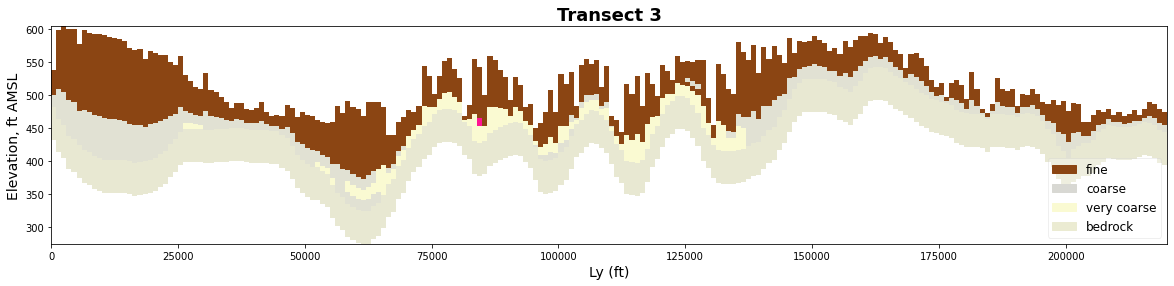

In [37]:
# Plot the 3 north-south transects
plot_transect("Transect 1", rowcolflag=1, value=31)  #transect 1: 90.14W
plot_transect("Transect 2", rowcolflag=1, value=52)  #transect 2: 90.06w
plot_transect("Transect 3", rowcolflag=1, value=68)  #transect 3: 90.01w

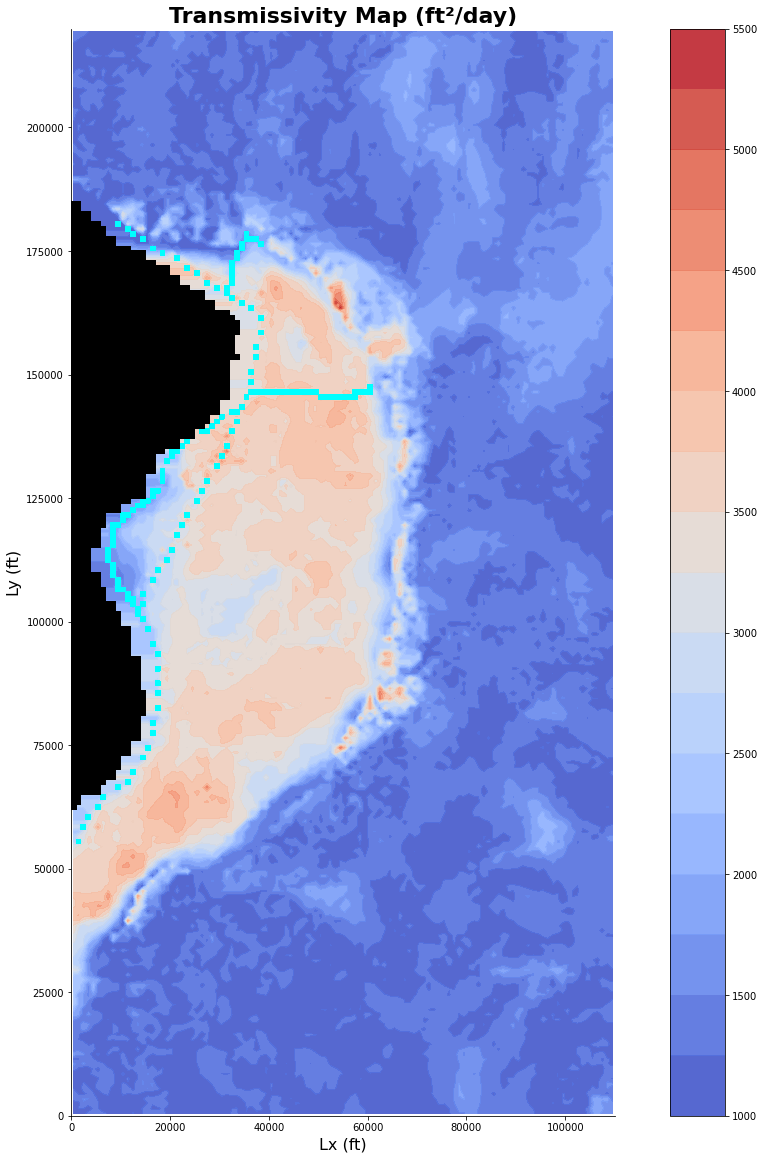

In [38]:
""" Plot Tranmsissivity map. """
modelmap = newmap("Transmissivity Map (ft²/day)")
plt.colorbar(plt.contourf(X, Y, T_flipped, 16, alpha=0.9,
                          cmap=plt.cm.coolwarm))  # Plot the transmissivity
add_ibound_riv() # add ibound and a river                        
plt.show()

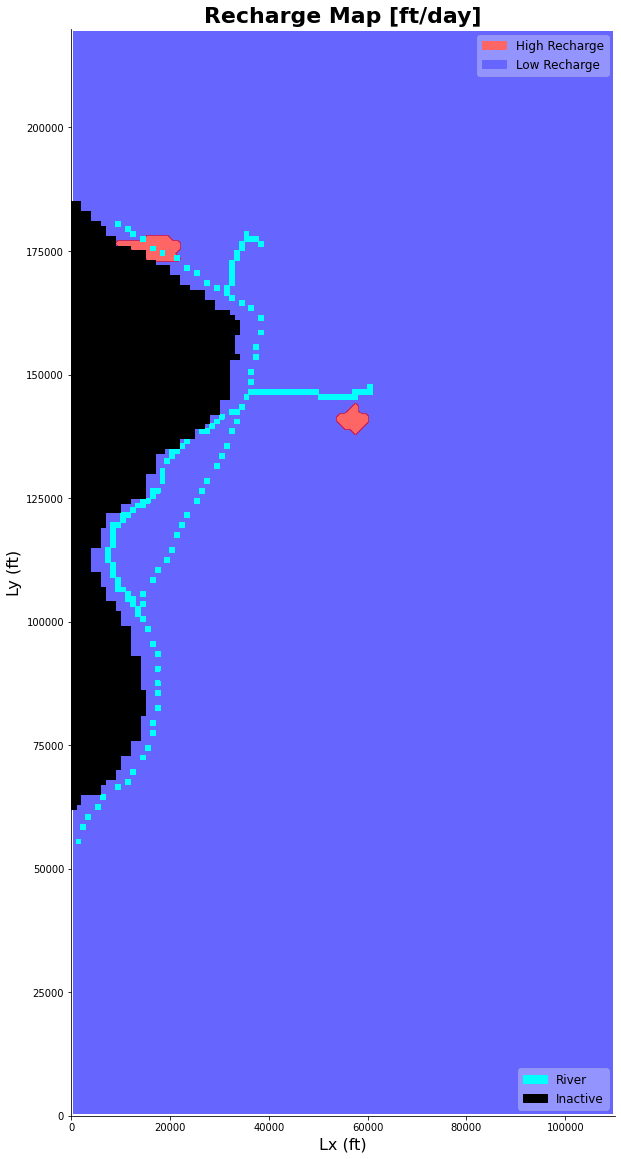

In [39]:
""" Plot Recharge map """
modelmap = newmap("Recharge Map [ft/day]")
plt.contourf(X, Y, rch_flipped, 1, alpha=0.6, cmap=plt.cm.seismic)  #seismic
sclegend = plt.legend(handles=[
    mp.patches.Patch(color='#FE6666', label='High Recharge'),
    mp.patches.Patch(color='#6666FF', label='Low Recharge')],
    fontsize=12, framealpha=0.3)
plt.gca().add_artist(sclegend) 
add_ibound_riv(1) # add ibound and a river 
plt.show()

# 4 Write and run the MODFLOW model

In [40]:
# Write the model input
m.write_input()
# Execute the model run
success, mfoutput = m.run_model(pause=False, report=True)
# Report back if the model did not successfully complete
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/09 22:30:02

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/05/09 22:30:19
 Elapsed run time: 16.374 Seconds

  Normal termination of simulation


# 5 Plot Output Data and model calibration

In [0]:
'''Extract binary data from head and flow files'''
#extract binary data from head file as flopy head object
headobj = flopy.utils.binaryfile.HeadFile(modelname + '.hds')
#extract head data from head object
head = headobj.get_data(totim=1.0)
# Set heads of inactivated cells to NAN (for plotting purpose)
head1 = np.where(head[0] < 0, 321, head[0])
head1 = np.flipud(head1)  # data was upside down, let's flip it.

In [0]:
"""Import historical groundwater head data and modify the format for further comparison."""
dfhist = pd.read_excel(
    'https://github.com/Firas-95/GEO572-Project-E.St.Louis/blob/master/flopy/EastStLouis_gwmassmeas.xlsx?raw=true'
)
dfhist = dfhist[["lat", "long", "y1995"]]
# Cut the items with no data
dfhist = dfhist.dropna(how='any')
# Cut the outliers for the historical data
dfhist = dfhist.loc[dfhist['lat'] < ne_lat]
dfhist = dfhist.loc[dfhist['long'] < ne_long]
dfhist = dfhist.loc[dfhist['lat'] > sw_lat]
dfhist = dfhist.loc[dfhist['long'] > sw_long]
# convert lat and long to lambert coorindates for historical data
lat_list, long_list = dfhist["lat"].tolist(), dfhist["long"].tolist()
lat_list, long_list = transformer.transform(lat_list, long_list)
dfhist["lam_x"] = [round(i/ 0.3048006096,0) for i in lat_list]
dfhist["lam_y"] = [round(j / 0.3048006096,0) for j in long_list]
# fit coordinates into the model
truncate(dfhist, "lam_x", "lam_y") # find corresponding rows and columns
dfhist = dfhist.groupby(['row', 'col'], as_index=False).mean()
dfhist['x'] = dfhist['col'] * dy + dy / 2
dfhist['y'] = 220000 - (dfhist['row'] * dx + dx / 2)
dfhist = dfhist.drop(["lat", "long", "lam_x", "lam_y"], axis=1)
model = []
for index, row in dfhist.iterrows():
    model.append(head[0][int(row["row"])][int(row["col"])])
dfhist['model'] = model
dfhist = dfhist.dropna(how='any')
# Compute the difference between the model and the observation.
dfhist['diff'] = dfhist['model'] - dfhist['y1995']

/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


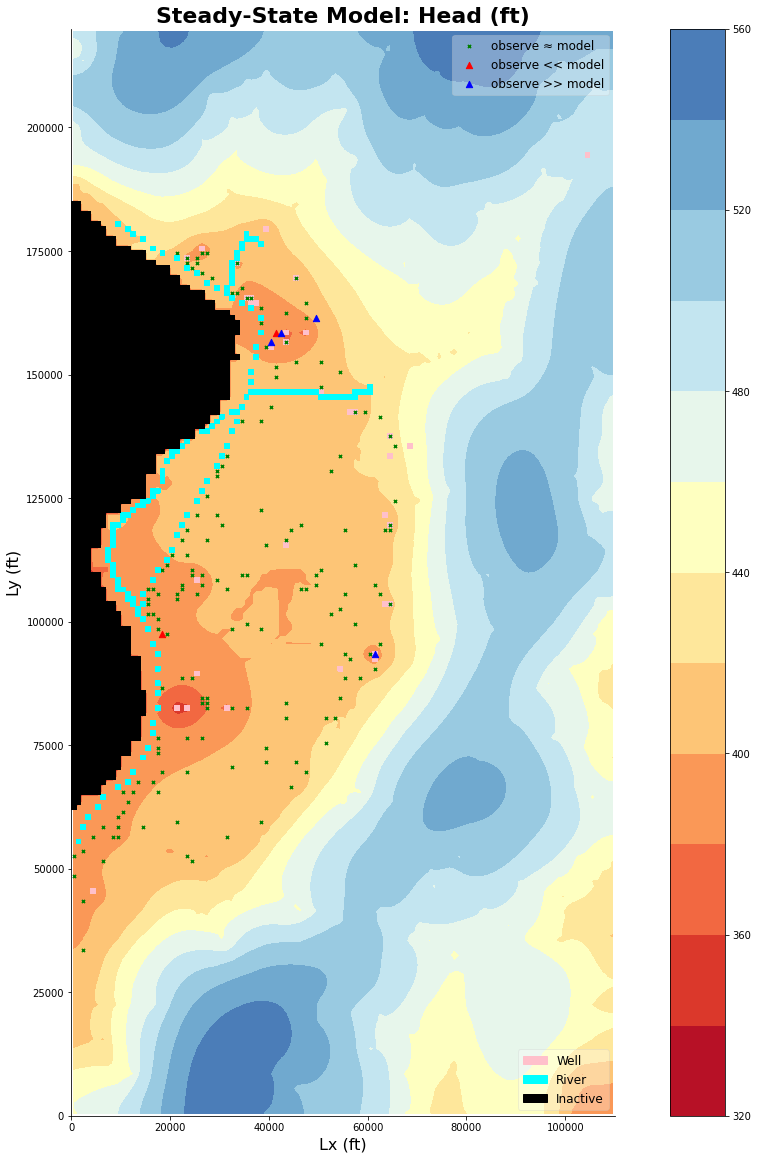

In [43]:
"""Plot steady-state head results."""
modelmap = newmap("Steady-State Model: Head (ft)")
plt.colorbar(plt.contourf(X, Y, head1, 14, vmax=580, vmin=320, cmap=plt.cm.RdYlBu))
# Plot the observed values on the map. Use different colors to see whether this point is well modeled.
pup = modelmap.plot_bc(ftype='WEL', color='pink', plotAll=True)
for index, row in dfhist.iterrows():
    if np.abs(row["model"] - row["y1995"]) < 15:  # green: observe ≈ model
        sc1 = plt.scatter(row['x'], row['y'], marker='x', color='green', s=10)
    elif row["model"] - row["y1995"] > 15:  # blue: observe << model
        sc2 = plt.scatter(row['x'], row['y'], marker='^', color='red', s=40)
    else:  # red: observe >> model
        sc3 = plt.scatter(row['x'], row['y'], marker='^', color='blue', s=40)

sclegend = plt.legend([sc1, sc2, sc3],
    ['observe ≈ model', 'observe << model', 'observe >> model', "well"],
    loc='upper right', fontsize=12,framealpha=0.3)
plt.gca().add_artist(sclegend) # add legend to the map
plt.legend(handles=[
    mp.patches.Patch(color='pink', label='Well'),
    mp.patches.Patch(color='aqua', label='River'),
    mp.patches.Patch(color='black', label='Inactive')],
           framealpha=0.3, loc="lower right", fontsize=12)
add_ibound_riv() # add ibound and a river
plt.show()

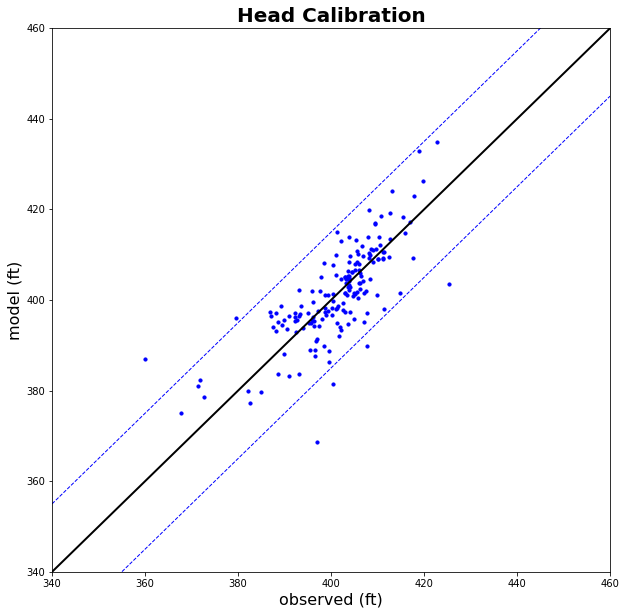

Mean error = 0.21 ft
Mean absolute error = 5.13 ft


In [44]:
"Create the calibration plot."
plt.figure(figsize=[10, 10], facecolor="white")
plt.scatter(dfhist["y1995"], dfhist["model"], color='blue', s=10)
plt.xlabel('observed (ft)', fontsize=16)
plt.ylabel('model (ft)', fontsize=16)
# plt.axis("equal")
plt.xlim(340,460)
plt.ylim(340,460)
plt.title('Head Calibration', fontsize=20, fontweight='bold')
xx = np.linspace(340, 460, 90)
plt.plot(xx, xx, '-k', linewidth=2)
plt.plot(xx, xx - 15, '--b', linewidth=1)
plt.plot(xx, xx + 15, '--b', linewidth=1)
plt.show()
print("Mean error =", round(dfhist['diff'].mean(), 2), "ft")
print("Mean absolute error =", round(np.abs(dfhist['diff']).mean(), 2), "ft")

# 6 Determine "pre-development" conditon

In [0]:
"""Run the model again, but remove the well package this time."""
modelname = "my_model"  
m = flopy.modflow.Modflow(modelname, version='mf2005', exe_name='mf2005')
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=topgrid, botm=botgrids, 
                               itmuni = 4, lenuni = 1, nper=nper, steady=steady)
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=topgrid)
lpf = flopy.modflow.ModflowLpf(model=m, hk=khlayers, vka=kvlayers,
                               laytyp=laytyp, ipakcb=1)
rch = flopy.modflow.mfrch.ModflowRch(model=m,nrchop=1,rech=rech)
riv = flopy.modflow.mfriv.ModflowRiv(model=m, ipakcb=None,
                                     stress_period_data=riverdata)
drn = flopy.modflow.mfdrn.ModflowDrn(model=m, ipakcb=None,
                                     stress_period_data=draindata)
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=200, iter1=50,
                               hclose=1e-03, rclose=1e-03, relax=0.98, damp=0.3)

In [46]:
"""Write and run the MODFLOW model"""
m.write_input()
# Execute the model run
success, mfoutput = m.run_model(pause=False, report=True)
# Report back if the model did not successfully complete
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/09 22:30:23

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/05/09 22:30:37
 Elapsed run time: 14.108 Seconds

  Normal termination of simulation


In [0]:
"""Get heads under pre-development conditions."""
headobj = flopy.utils.binaryfile.HeadFile(modelname + '.hds')
#extract head data from head object
head = headobj.get_data(totim=1.0)
head2 = np.where(head[0] < 0, 321, head[0])
head2 = np.flipud(head2)  # data was upside down, let's flip it.

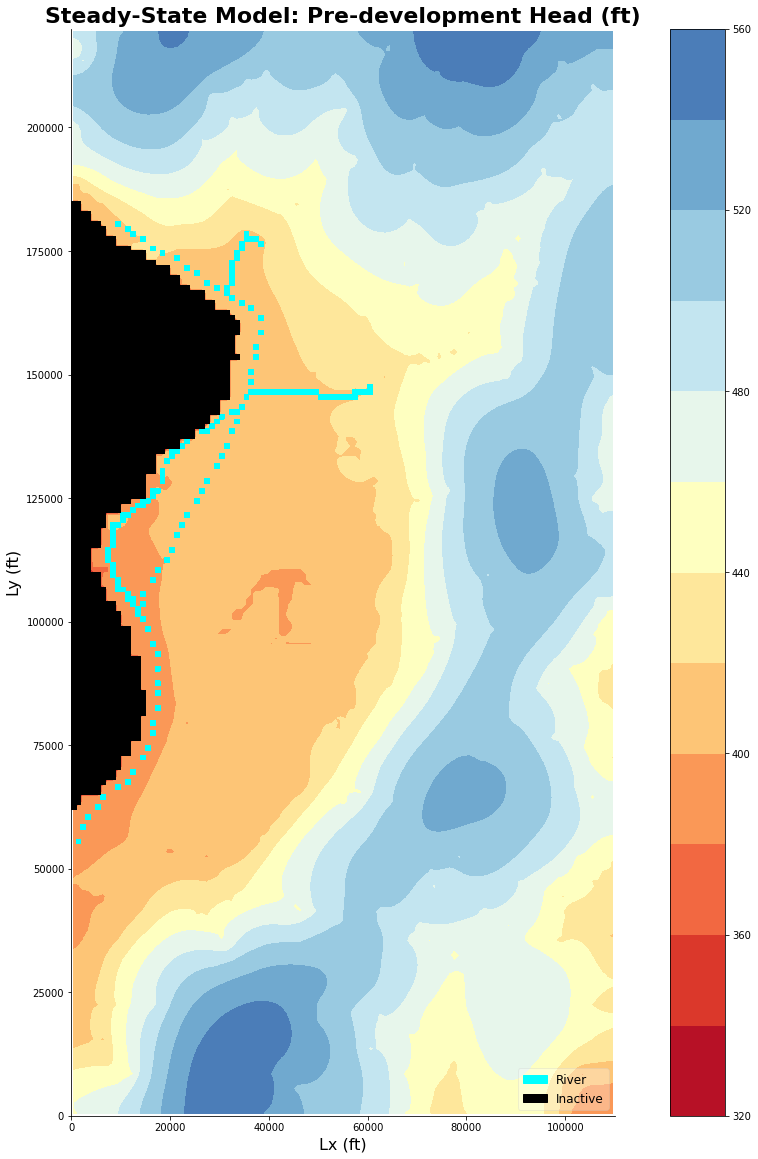

In [48]:
"""Plot steady-state pre-development head results."""
modelmap = newmap("Steady-State Model: Pre-development Head (ft)")
plt.colorbar(plt.contourf(X, Y, head2, 14, vmax=580, vmin=320, cmap=plt.cm.RdYlBu))
plt.legend(handles=[
    mp.patches.Patch(color='cyan', label='River', ec='aqua'),
    mp.patches.Patch(color='black', label='Inactive', ec='black')
],
           loc="lower right",
           fontsize=12)
add_ibound_riv(1) # add ibound and a river
plt.show()

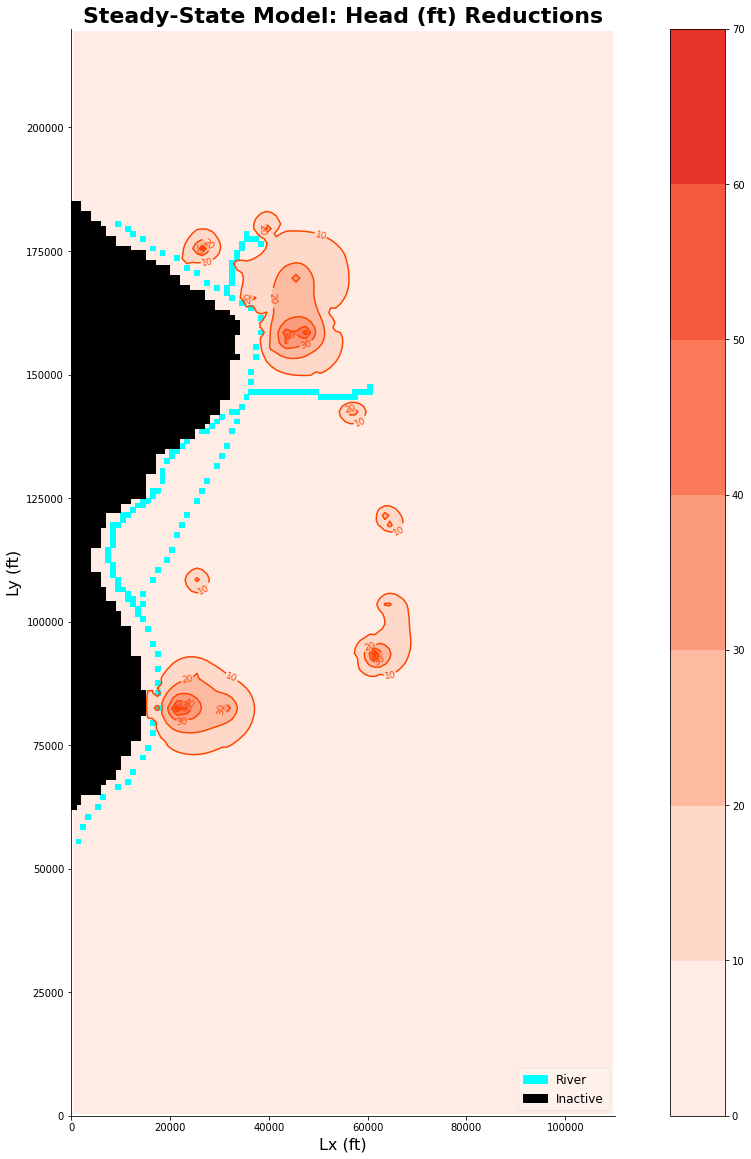

In [49]:
modelmap = newmap("Steady-State Model: Head (ft) Reductions")
# "head2-head1+ 0.001" can avoid negative values.
plt.colorbar(plt.contourf(X, Y, head2-head1+0.001, 7,vmax=100,cmap=plt.cm.Reds))
# Create contour lines
cset = plt.contour(X,Y,head2-head1+0.001,np.arange(0, 80, 10),colors='orangered')
pylab.clabel(cset, fontsize=9,fmt='%1.0f')
plt.legend(handles=[mp.patches.Patch(color='cyan', label='River', ec='aqua'),
                    mp.patches.Patch(color='black', label='Inactive', ec='black')],
                    loc="lower right", fontsize=12)
add_ibound_riv(1) # add ibound and a river
plt.show()